In [1]:
from qiskit import *
from qiskit.visualization import *
from qiskit.providers.aer import AerSimulator
from numpy import *
from cmath import *

I = identity(2)
X = matrix([[0, 1],[1, 0]])
Y = matrix([[0, 1j],[-1j, 0]])
Z = matrix([[1, 0],[0, -1]])
H = 1/sqrt(2)*matrix([[1, 1], [1, -1]])
p0 = matrix([[1, 0],[0, 0]])
p1 = matrix([[0, 0],[0, 1]])
def W(theta):
    return matrix([[cos(theta), sin(theta)], [sin(theta), -cos(theta)]])
CX = kron(p0, I)+kron(p1, X)
CZ = kron(I, H)*CX*kron(I, H)

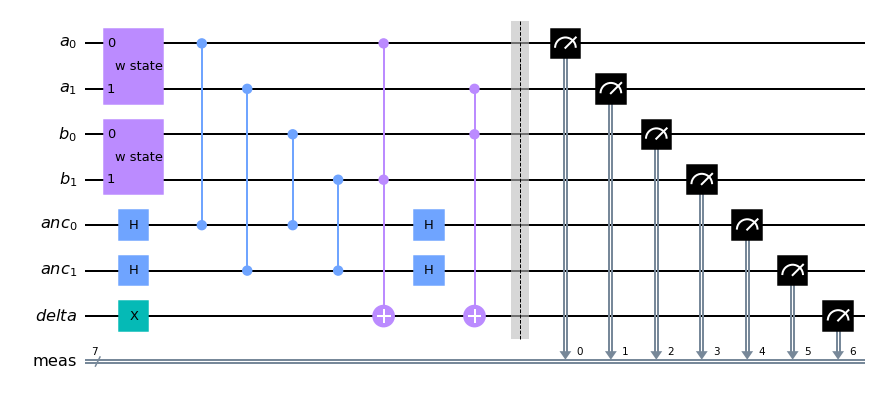

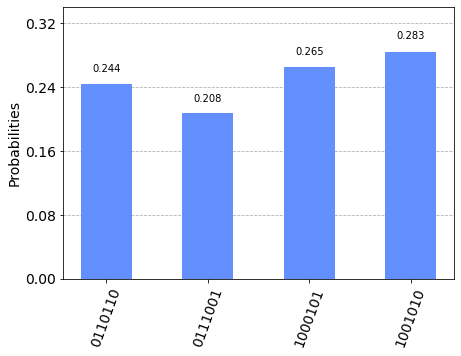

In [2]:
w = QuantumCircuit(2, name='w state')
w.h(0)
w.x(1)
w.cx(0, 1)
display(w.draw(output='mpl'))

w = w.to_instruction()

qc = QuantumCircuit()

a = QuantumRegister(2, 'a')
b = QuantumRegister(2, 'b')
anc = QuantumRegister(2, 'anc')
delta = QuantumRegister(1, 'delta')
#out = ClassicalRegister(2)
qc.add_register(a)
qc.add_register(b)
qc.add_register(anc)
qc.add_register(delta)
#qc.add_register(out)

# convert to X-basis
qc.h(anc)
qc.x(delta)

qc.append(w, a)
qc.append(w, b)

qc.cz(anc, a)
qc.cz(anc, b)

qc.ccx(a[0], b[1], delta)
qc.ccx(a[1], b[0], delta)

# convert back to Z-basis
qc.h(anc)

qc.measure_all()

display(qc.draw(output='mpl'))
backend = Aer.get_backend('aer_simulator')
tqc = transpile(qc, backend)
result = backend.run(tqc).result()
plot_histogram(result.get_counts())

## Quantum circuit for solving all valid N-queens arrangements

- Algorithm: https://arxiv.org/pdf/1806.10221.pdf
- Generalized W-state: https://arxiv.org/pdf/1606.09290.pdf

### State representation

The arrangement of the queens is represented by an $N×N$ matrix where $1$s are queens and $0$s are vacancies.

The output from the algorithm, for example $0100\_0001\_1000\_0010$ represents the matrix

$$
\begin{pmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
\end{pmatrix}
$$

The qubits from $0..N^2$ reperesent the qubits of the rows concatenated starting from the top row.

Using 26 qubits


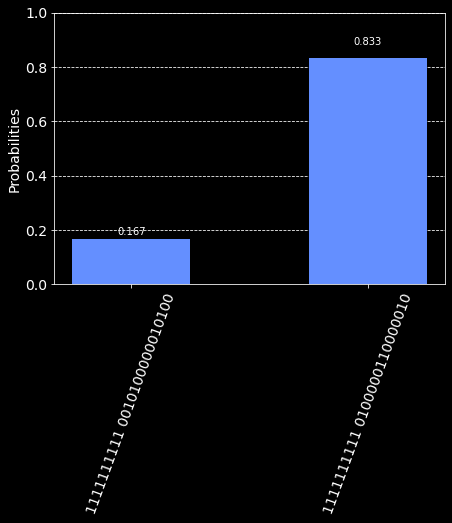

<IPython.core.display.Latex object>

[[0 0 1 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 1 0 0]]


<IPython.core.display.Latex object>

[[0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]]


In [17]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

N = 4

# W-state sub circuit

w = QuantumCircuit(N)
def F(n, qc):
    theta = 1/2*arccos(1/sqrt(n)) # note: paper (12) is wrong, 1/4 is incorrect

    qc.unitary(W(theta), N-n+1, label=f'W{n}')
    qc.cz(N-n+1, N-n)
    qc.unitary(W(theta), N-n+1, label=f'W{n}')

w.x(0)
for n in range(N - 1):
    F(N - n, w)
    w.cx(n + 1, n)

display(w.draw(output='mpl'))
w = w.to_instruction(label="W state")

# N-queens circuit

qc = QuantumCircuit()

rows = []

for n in range(N):
    rows.append(QuantumRegister(N, f'r{n}'))

# ancillas used for columns checking
anc = QuantumRegister(N, 'anc')

# ancillas used for diagonal checking
delta = QuantumRegister((N**2-N)/2, 'delta')

for row in rows:
    qc.add_register(row)
qc.add_register(anc)
qc.add_register(delta)

# convert ancillas to X-basis
qc.h(anc)

for row in rows:
    # prepare W-state for each row
    qc.append(w, row)
    
    # calculate XOR for each column
    qc.cz(anc, row)

# convert back to Z-basis
qc.h(anc)

qc.x(delta)

qc.barrier()

# diagonals
for i in range(1, N + 1):
    for j in range(i + 1, N + 1):
        for x in range(1, N + 1):
            for y in range(1, N + 1):
                if abs(i-j) == abs(x-y):
                    k = int((i-1)/2*(2*N-i))+j-i
                    # print(f"CCX {i}{x} & {j}{y} <> {k}")
                    q1 = rows[i-1][x-1]
                    q2 = rows[j-1][y-1]
                    qc.ccx(q1, q2, delta[k-1])
                    
# measure chess board
qc.barrier()

board = ClassicalRegister(N**2, 'board')
qc.add_register(board)
qc.measure([q for row in rows for q in row], board)

# measure checks
checklen = int((N**2 + N)/2)
checks = ClassicalRegister(checklen, 'checks')
qc.add_register(checks)
qc.measure(anc, checks[:N])
qc.measure(delta, checks[N:])

print(f"Using {N**2 + checklen} qubits")

display(qc.draw(output='mpl'))
backend = AerSimulator(method='statevector')

tqc = transpile(qc, backend)
result = backend.run(tqc, shots=1000).result()

def check_valid(result):
    return not ('0' in result[0][:checklen])

display(plot_histogram(result.get_counts()))

filtered = dict(filter(check_valid, result.get_counts().items()))

if len(filtered) == 0:
    print(f"No valid arrangement of {N} queens found")
else:
    display(plot_histogram(filtered))
    for solution in filtered:
        queens = array(list(map(int, solution[checklen+1:]))).reshape(N, N)
        display(array_to_latex(queens))
        print(queens)

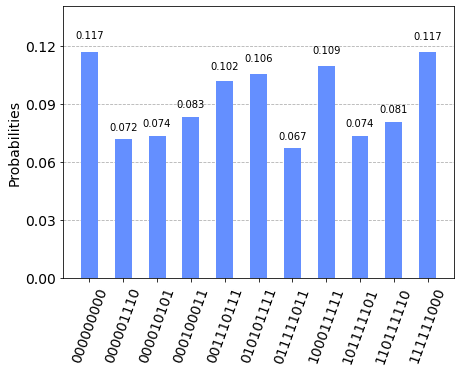

In [4]:
N = 3

# W-state sub circuit

w = QuantumCircuit(N)
def F(n, qc):
    theta = 1/2*arccos(1/sqrt(n)) # note: paper (12) is wrong, 1/4 is incorrect

    qc.unitary(W(theta), N-n+1, label=f'W{n}')
    qc.cz(N-n+1, N-n)
    qc.unitary(W(theta), N-n+1, label=f'W{n}')

w.x(0)
for n in range(N - 1):
    F(N - n, w)
    w.cx(n + 1, n)

w = w.to_instruction(label="W state")

# N-queens circuit

qc = QuantumCircuit()

rows = []

for n in range(N):
    row = QuantumRegister(N, f'r{n}')
    rows.append(row)
    qc.add_register(row)

for row in rows:
    qc.append(w, row)
    qc.h(row)

columns = [[row[i] for row in rows] for i in range(N)]

for col in columns:
    qc.append(w, col)

qc.measure_all()    

display(qc.draw(output='mpl'))
backend = AerSimulator(method='statevector')

tqc = transpile(qc, backend)
result = backend.run(tqc, shots=10000).result()

filtered = dict(filter(lambda result: result[1] > 300, result.get_counts().items()))

plot_histogram(filtered)